# Using age, blood pressure and cholesterol to classify if a patient has heart disease

#### Oscar Jiang, Tina Zeng, Nick Luu, Jake Fung

## Introduction


Heart disease is a general term for a variety of conditions that affect your heart and blood vessels. These conditions can damage your heart, restrict blood flow, and lead to serious complications, including heart attack, stroke, and heart failure. With 20.5 million U.S. adults have coronary artery disease, heart disease is the leading cause of death in the United States (U.S. Department of Health and Human Services, 2023). 

Age is a major risk factor for heart disease due to several factors. Arteries stiffen and weaken, reducing blood flow and putting strain on the heart. Plaque buildup in arteries worsens with age, further restricting blood flow and increasing the risk of heart attack and stroke (Rodgers, J. L. et al., 2019).

Chronically high blood presssure can damage arteries, making them more prone to plaque buildup and narrowing (Centers for Disease Control and Prevention, 2021).

High levels of LDL cholesterol, often called "bad" cholesterol, can contribute to heart disease by accumulating in arteries and forming plaque. This plaque narrows the arteries, reducing blood flow and increasing the risk of complications like chest pain, blood clots, heart attack, and stroke(Centers for Disease Control and Prevention, 2017).

Based on the research our team found, we will be using the UC Irvine Heart Disease dataset in order to answer the following research question.
The dataset that we are using explores 271 patients and their situation across multiple variables, and finally classifying if they have heart disease. With that in mind, we formed the following classification question:

**Research Question:** Can we classify if a patient has heart disease based on age, blood pressure and cholesterol? 

## Preprocessing and Exploratory Data Analysis

### Importing libraries

In [1]:
set.seed(2024)
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor) #Install to use the clean_names() function.

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### Importing the dataset
The data set for heart disease was upload first to GitHub and, using the GitHub link, we read the file with the `read_csv` function. 

In [2]:
heart <- read_csv("https://raw.githubusercontent.com/jake-fung/DSCI100-002-031-GroupProject/main/data/Heart_Disease_Prediction.csv?token=GHSAT0AAAAAACPBQC4C2ZZQCWQSIKDWFDPCZPM6QOQ") 

Rows: 270 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Heart Disease
dbl (13): Age, Sex, Chest pain type, BP, Cholesterol, FBS over 120, EKG resu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Cleaning and tidying the data

We clean and tidy the data in order for preparing the data analysis.
1. We use `clean_names` to clean the column names to make data easier to work with.
2. Converting `heart_disease` to a factor for effective statistical analysis

In [3]:
heart <- clean_names(heart)

heart <- heart |>
mutate(heart_disease = as_factor(heart_disease))

### Splitting the data into training and testing sets
We use the `initial-split` function to split data into training and testing data set. The 80-20 split provides enough training data to observe patterns, while still maintaining a decent-sized test set for evaluation for us later.

In [4]:
set.seed(2024)
heart_split <- initial_split(heart, prop = 0.80, strata = heart_disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

### Summarising the data
1. First, we filtered out only the predictors we want to predict, in this case, `age`, `bp`, `cholesterol`, in order to predict the factor `heart _disease`, we store it in `heart_filtered`.
2. We calculate the means of the predictors using `mean` and `map_df` function, and store them in `heart_mean`.
3. We count the heart disease occurrences using `group_by` and `summarize` function. we store it in `heart_amount` data frame.
4. We created `heart_summary_1` to gain an overview of average values and the total counts for the selected variables.
5. We created `heart_summary_2` to provide a more detailed view of average age, cholesterol and blood pressure that falls under the presence and absence of heart disease category.

In [5]:
set.seed(2024)

heart_filtered <- heart_train |>
select(age, bp, cholesterol, heart_disease)

heart_mean <- heart_filtered|>
select(-heart_disease) |>
map_df(mean)

heart_amount <- heart_filtered|>
group_by(heart_disease) |>
summarize(amount=n())

heart_summary_1 <- bind_cols(heart_mean, heart_amount) |>
pivot_wider(names_from=heart_disease,
            values_from=amount) |>
rename(age_avg=age, bp_avg=bp, chol_avg=cholesterol, hd_absence=Absence, hd_presence=Presence)
heart_summary_1

heart_summary_2 <- heart_train |>
group_by(heart_disease) |>
summarize(patients = n(),
         avg_age = mean(age),
         chol_avg = mean(cholesterol),
         bp_avg = mean(bp))
heart_summary_2

age_avg,bp_avg,chol_avg,hd_presence,hd_absence
<dbl>,<dbl>,<dbl>,<int>,<int>
54.43981,131.0185,247.9306,96,120


heart_disease,patients,avg_age,chol_avg,bp_avg
<fct>,<int>,<dbl>,<dbl>,<dbl>
Presence,96,56.63542,255.4271,134.3646
Absence,120,52.68333,241.9333,128.3417


### Visualising the data
We select the predictors we want for analysis by the `gg_plot` function. Histograms make it easy to approximate where most of the data is concentrated, giving us the central point of average between the presence/absence data.
1. The `histogram_bp` will show the distribution of people with or without heart disease and their blood pressure.
2. The `histogram_ch` will show the distribution of people with or without heart disease and their cholesterol.
3. The `histogram_age` will show the distribution of people with or without heart disease and their age.

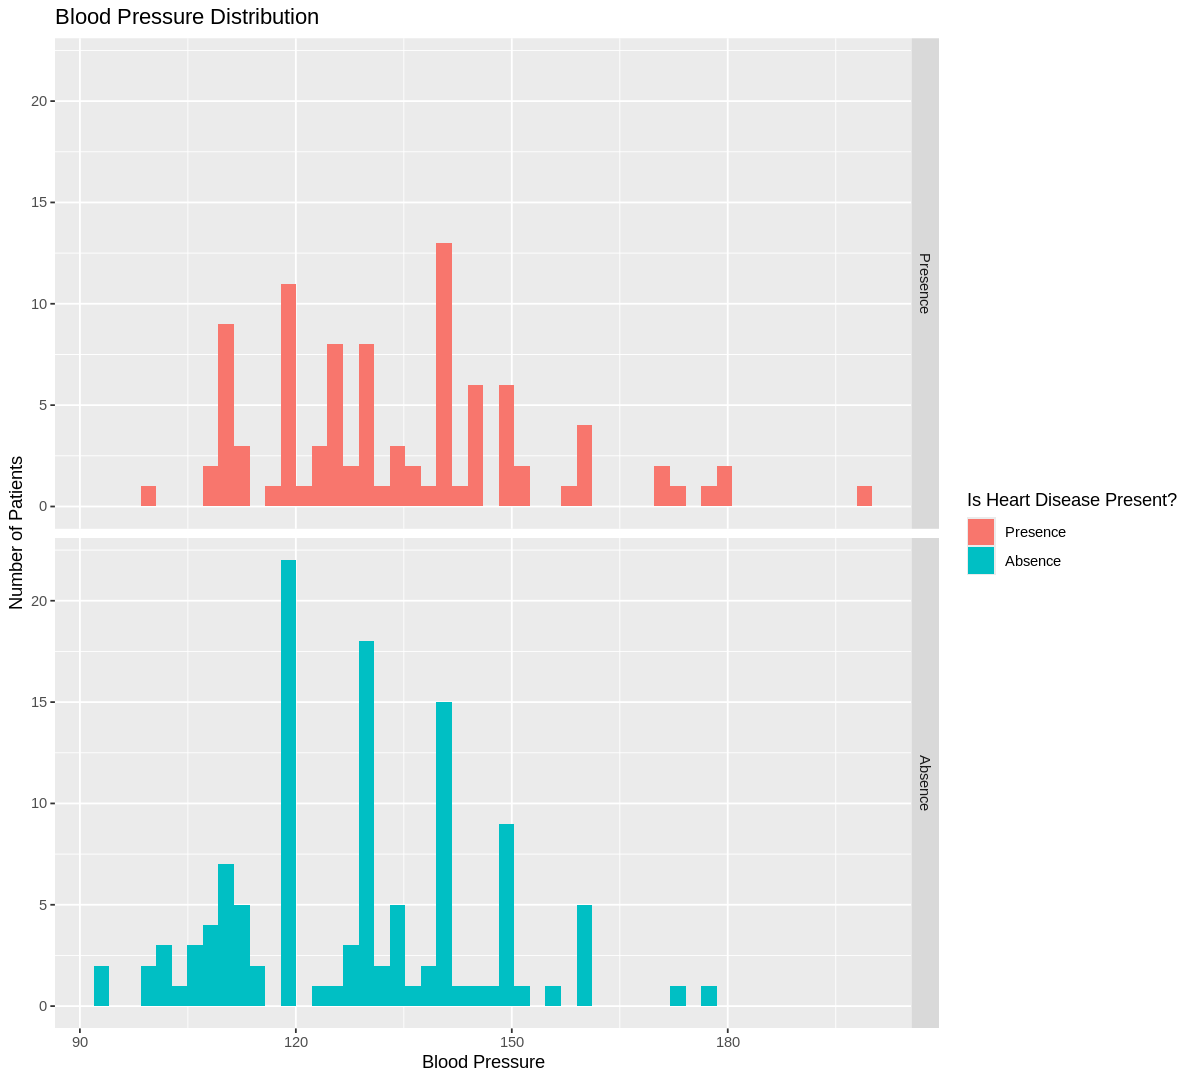

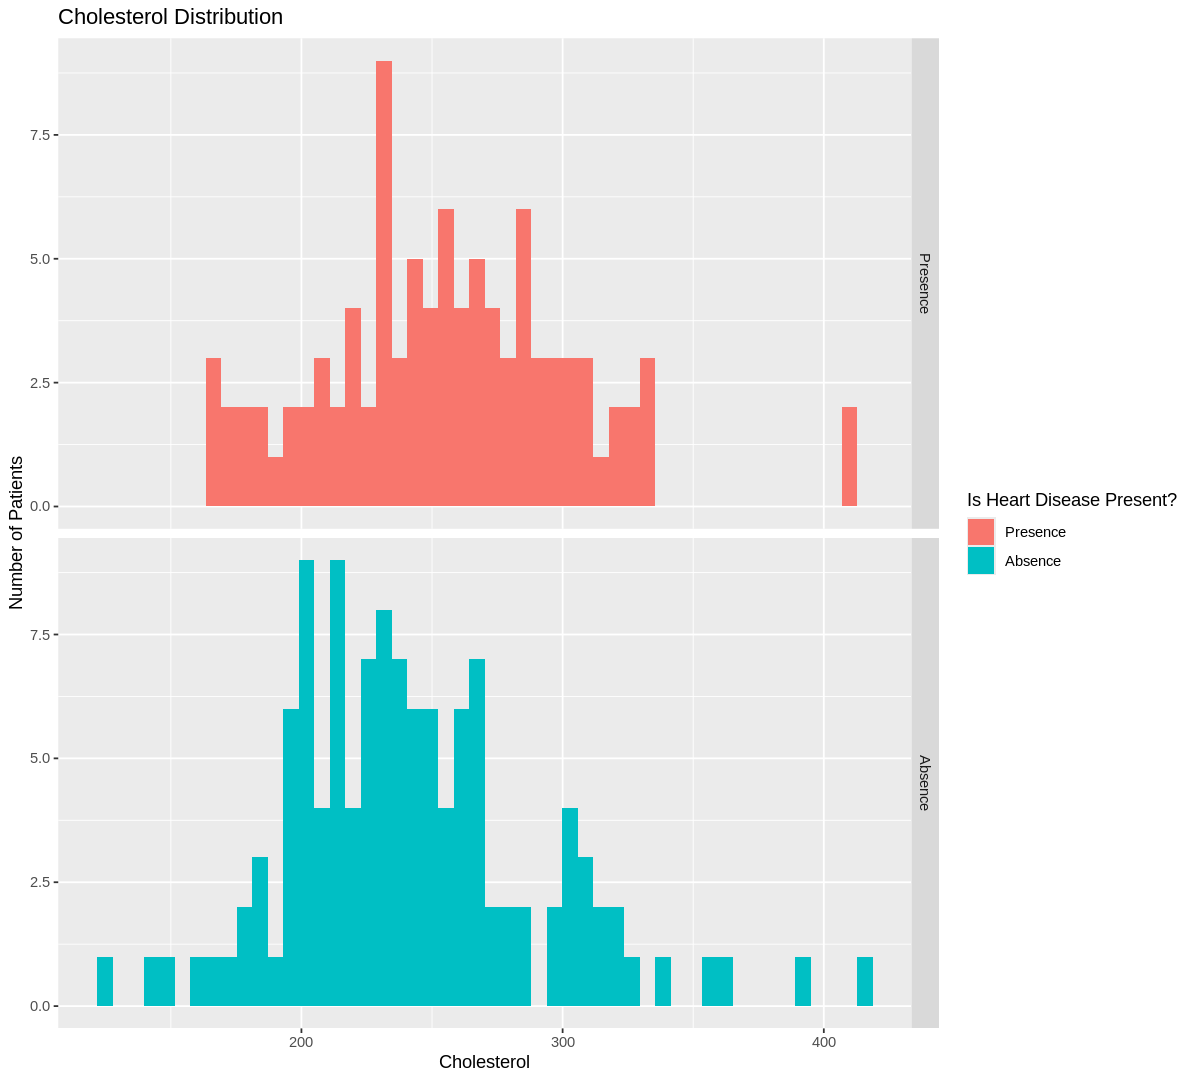

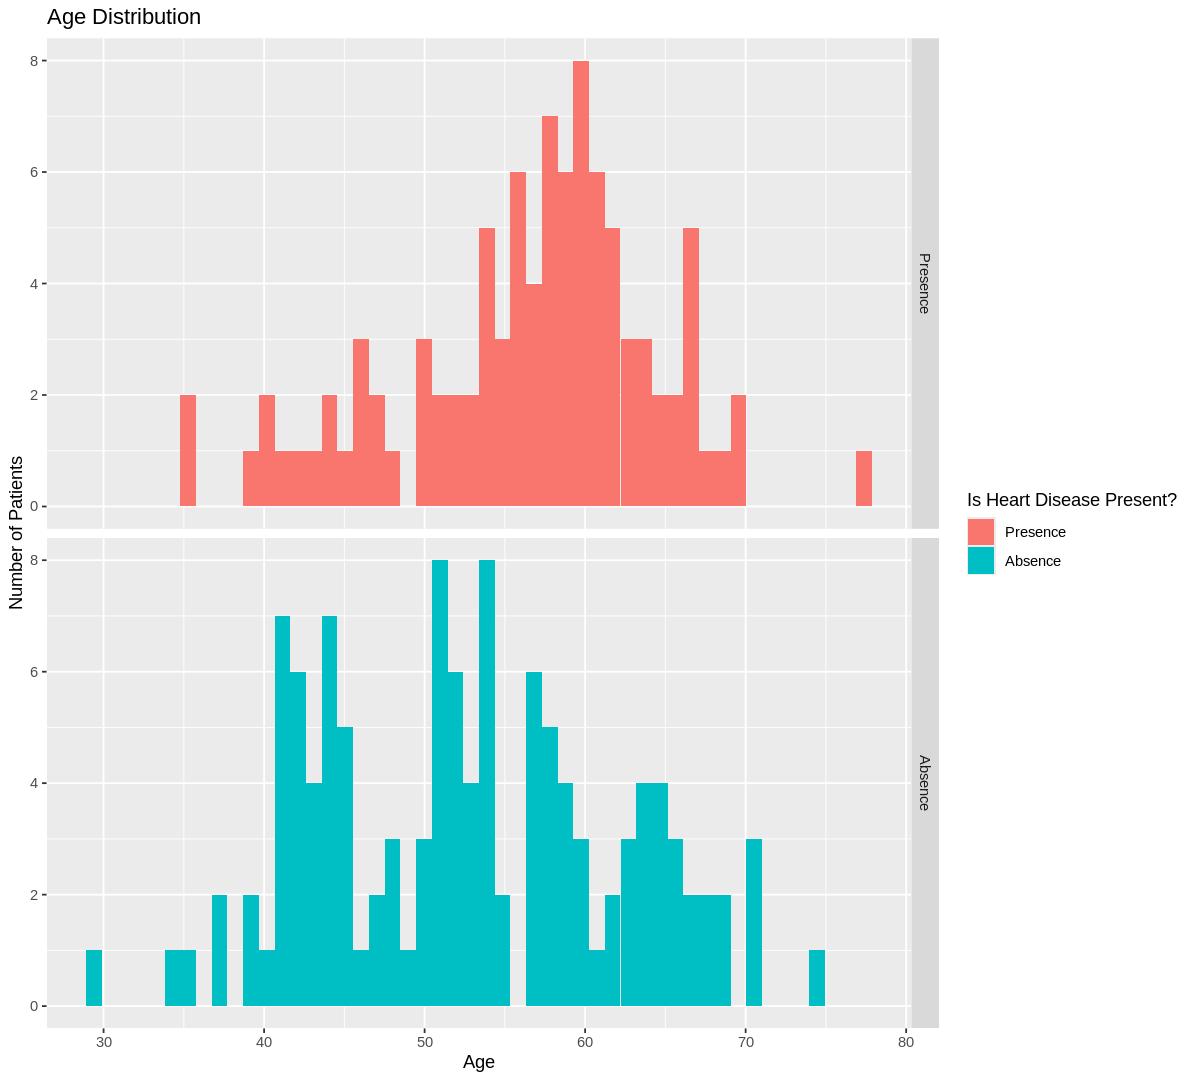

In [6]:
set.seed(2024)
options(repr.plot.width = 10, repr.plot.height = 9)

histogram_bp <- heart_filtered |>
ggplot(aes(x = bp, fill = heart_disease)) +
geom_histogram(bins=50) +
facet_grid(vars(heart_disease))+
labs(x = "Blood Pressure", y = "Number of Patients", fill = "Is Heart Disease Present?")+
ggtitle("Blood Pressure Distribution")
histogram_bp

histogram_ch <- heart_filtered |>
ggplot(aes(x = cholesterol, fill = heart_disease)) +
geom_histogram(bins=50) +
facet_grid(vars(heart_disease))+
labs(x = "Cholesterol", y = "Number of Patients", fill = "Is Heart Disease Present?")+
ggtitle("Cholesterol Distribution")
histogram_ch

histogram_age <- heart_filtered |>
ggplot(aes(x = age, fill = heart_disease)) +
geom_histogram(bins=50) +
facet_grid(vars(heart_disease))+
labs(x = "Age", y = "Number of Patients", fill = "Is Heart Disease Present?")+
ggtitle("Age Distribution")
histogram_age

Looking at the graphs, there are visible bumps where heart disease is present in all of the graphs. Similarly, there are is a separate bump for the absent group. Only the blood pressure histogram is the data spread out; however, in the other histograms, the data is pretty much grouped together. 

# Methods
To answer our research question proposed above, we will be using 4 columns from the original dataset. We will create a histogram with each variable against the number of patients with heart disease to find if they are good predictors; an example of this is in the exploratory data analysis. Then, we will be using the K-nearest neighbours classification model with the heart disease column as the class and age, cholesterol, and blood pressure as the predictors. Since these values are not scaled, we will need to standardize these variables. Since we are using three numerical variables, we may need to use multiple graphs to visualize our results. An example of one graph may be a scatterplot with blood pressure and cholesterol with the presence of heart disease to differentiate the points. Then an unknown observation may be plotted on the same scatterplot with lines that lead to the nearest data points around it to see how our classifier performed the prediction. 

# Data Analysis

### Setting the best value of K
To create our model, we use the K-nearest neighbors(KNN) for heart disease classification:
1. We set up the model with `neighbors` set to `tune()`, this is uses to find the optimal number of neighbors.
2. We create the recipe using all columns as a predictor with the `recipe` function, while standardizing the data.
3. We define a 10-fold cross-validation for the model by the `vfold` function, this ensure our good evaluation of the model performance.
4. We uses a set of k-values from 1 to 100 in increments of 2, this can provides us the choices of k we can decide for our model later on.
5. The recipe and model are put into a workflow. The `tune_grid()` function trains the model with each k value and collects the metrics associated with each model.

In [ ]:
set.seed(2024)
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

heart_recipe <- recipe(heart_disease ~ ., data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_vfold <- vfold_cv(heart_train, v = 10, strata = heart_disease)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

heart_knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics()

print("Table 3 - The accuracies for all the K values")
accuracies_h <- heart_knn_results |>
  filter(.metric == "accuracy")
accuracies_h


### Visualising the data
We set `x = neighbors`, `y = mean` in one graph with `geom_point()` and `geom_line()` to visualize the best k we choose for our model.

In [ ]:
accuracy_vs_k <- ggplot(accuracies_h, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12)) + 
ggtitle("Figure 4 - Accurarcies for K values")
accuracy_vs_k

From the accuracies table, we can sort from the highest value of K then pull the neighbours. To do this, we use the `arrange()` and `desc()` function to sort all the k with accuracies in descending order.

In [ ]:
best_k <- accuracies_h |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

Therefore, our best k is `neighbors = 43`.

### Creating the final model with our best K selected
Now that we have the best value for k, we can create our final model.
To do this,
1. We set our `knn_spec` by using `best_k`.
2. We fit our `knn_spec` and `heart_recipe` into `heart_train` by the `workflow()`function.

In [ ]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_train)

knn_fit

### Testing our classifer
#### Accuracy
We finally use the testing set to look at how our classifier performs with data the model has never seen before. The accuracy shows the proportion of correct prediction by total prediction.

In [ ]:
heart_test_predictions <- predict(knn_fit, heart_test) |>
  bind_cols(heart_test)

print("Table 4 - The accuracy of the model")
heart_test_predictions |>
  metrics(truth = heart_disease, estimate = .pred_class) |>
  filter(.metric == "accuracy")

#### Precision
The precision shows the number of correct positive predictions over total positive predictions. To do this, we would use the `precision()` function.

In [ ]:
print("Table 5 - The precision of the model")
heart_test_predictions |>
    precision(truth = heart_disease, estimate = .pred_class, event_level="first")

#### Recall
The recall shows the proportion of correct positive predictions over total number of positive test set observations. To do this, we would use the `recall()` function.

In [ ]:
# The recall of the model can be found with the recall function
print("Table 6 - The recall of the model")
heart_test_predictions |>
    recall(truth = heart_disease, estimate = .pred_class, event_level="first")

#### Confusion matrix
The counfusion matrix is useful for idetifying the weakness of the model when classifying different data sets. To do this, we would use the `conf_mat` function.

In [ ]:
print("Table 7 - The confusion matrix of the model")
confusion <- heart_test_predictions |>
             conf_mat(truth = heart_disease, estimate = .pred_class)
confusion

Our classifier was 91% accurate and labeled 49 out of 54 observations correctly.

In [ ]:
heart_test_predictions_2 <- heart_test_predictions |>
select(.pred_class, heart_disease) |>
mutate(validity = .pred_class == heart_disease)

heart_test_2 <- heart_test |>
bind_cols(heart_test_predictions_2)

heart_test_2 |>
    select(-heart_disease...14)

test_heart <- heart_test_2 |>
  ggplot(aes(x = age, y = bp, color = validity)) +
  geom_point(alpha = 0.5) +
  labs(color = "Diagnosis") +
  scale_color_discrete(labels = c('Match', 'Does not Match')) +
  theme(text = element_text(size = 12)) 

### make a new column by mutating which has entries true or false, based on whether ur model's prediction matches the true prediction. plot this with age and bp and the legend will tell you whether the prediction is correct or not 

test_heart


# Expected outcomes and significance:
Our research question aims to find the link between cholesterol, blood pressure, age, and heart disease. Based on previous research, we are aware that cholesterol, blood pressure, and age have a significant effect on your health. With our research, we wish to determine if we can classify if a person has heart disease based on the values of those variables. The impact of this is that we can become aware of any serious health issues that may arise before it is too late. In the future we could add more variables to these our model and find out if there are more outstanding variables that contribute to having heart disease.

# Discussion:
## Summary of our findings:
Regarding the confusion table, our model predicted that it correctly classified 19 patients with heart disease and 30 patients without heart disease. Interestingly, the model did not predict any patients without heart disease as falsely present. However, the model did predict 3 patients with heart disease as falsely absent. As a result, the accuracy of our model was 91%, a precision of 100%, and a recall of 79%.

## Our expectations of the model:
From our preliminary analysis with our graphs in Figure 1 to Figure 3, we had originally thought that our model would not be as accurate as 90%. This is because the histogram graphs we used did not show any clear trends that indicated that each variable influenced whether or not the patient had heart disease. For example, in Figure 2 with cholesterol, we see that most people that have heart disease have around 240mg, but we also see that most people without heart disease also have around 240mg, so this seemed like this individual variable had little effect on having heart disease. However, we did know that these variables would have a different effect when combined, but we weren't sure how well the model would be able to correctly classify patients with heart disease, especially since we picked our predictors (which could have been unsuited for the job). Overall, our model surpassed our expectations with how precise it ended up.

## What impact does the finding have:
Considering that the accuracy of our model is 91%, we may assume that our variables, age, blood pressure, and cholesterol, are significant factors leading to heart disease.

## Future questions:
Our model had incorrectly diagnosed three patients with heart disease as people without heart disease, which is pretty problematic, even if our model is correct 90% of the time. Some questions this could lead to is if our model is simply incomplete, or if we just do not have enough information in our predictors to correctly classify if they have heart disease. Our model seems to have enough to do a very good job given the predictors we chose, but what if there were even better predictors that we should have chosen? For example, it could be possible that gender has more of an effect on if a person has heart disease, and if so, we should have included it. The main questions that stem from our analysis are how we can improve our model or if the predictors we chose were a good choice for this classification problem.

## Confusion table: 

In [ ]:
confusion

## Biblography

Centers for Disease Control and Prevention. (2017). LDL & HDL: Good & Bad Cholesterol. Centers for Disease Control and Prevention. https://www.cdc.gov/cholesterol/ldl_hdl.htm 

Centers for Disease Control and Prevention. (2021, May 18). About high blood pressure (hypertension). Centers for Disease Control and Prevention. https://www.cdc.gov/bloodpressure/about.htm

Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., Karia, K., & Panguluri, S. K. (2019). Cardiovascular Risks Associated with Gender and Aging. Journal of Cardiovascular Development and Disease, 6(2). https://doi.org/10.3390/jcdd6020019

U.S. Department of Health and Human Services. (2023, December 20). What is coronary heart disease?. National Heart Lung and Blood Institute. https://www.nhlbi.nih.gov/health/coronary-heart-disease

World Health Organization. (2020). Hypertension. World Health Organization. https://www.who.int/health-topics/hypertension#tab=tab_1